<a href="https://colab.research.google.com/github/alokp896/ML/blob/main/Sales_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Supplement Sales Prediction**
Your Client WOMart is a leading nutrition and supplement retail chain that offers a comprehensive range of products for all your wellness and fitness needs. 

WOMart follows a multi-channel distribution strategy with 350+ retail stores spread across 100+ cities. 

Effective forecasting for store sales gives essential insight into upcoming cash flow, meaning WOMart can more accurately plan the cashflow at the store level.

Sales data for 18 months from 365 stores of WOMart is available along with information on Store Type, Location Type for each store, Region Code for every store, Discount provided by the store on every day, Number of Orders everyday etc.

Your task is to predict the store sales for each store in the test set for the next two months.

Importing Libreries

In [ ]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import xgboost as xgb
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

### Creating Dataframe from CSV file

In [ ]:
df_train = pd.read_csv('TRAIN.csv')
df_test = pd.read_csv('TEST_FINAL.csv')

### Checking That any column containing null/none value

In [ ]:
df_train.isnull().sum()

ID               0
Store_id         0
Store_Type       0
Location_Type    0
Region_Code      0
Date             0
Holiday          0
Discount         0
#Order           0
Sales            0
dtype: int64

### Concatinating the train and test data for data preprocessing. Adding Train flag to seperate the training and test Data

In [ ]:
df_train['train_flag'] = 1
df_test['train_flag'] = 0
df_test['Sales'] = None
print(df_train.shape, df_test.shape)

df_data = pd.concat((df_train, df_test))
print(df_data.shape)

(188340, 11) (22265, 10)
(210605, 11)


### handling Date feature

In [ ]:
df_data['Date'] = pd.to_datetime(df_data['Date'], errors='coerce')
df_data['Year'] = df_data['Date'].dt.year
df_data['Month'] = df_data['Date'].dt.month
df_data['Day'] = df_data['Date'].dt.day

### Removing non unique features

In [ ]:
cols = df_data.columns
for column in cols:
  print('Numbers of Unique Category for ',column, 'are : ', df_data[column].nunique())

Numbers of Unique Category for  Holiday are :  2
Numbers of Unique Category for  Sales are :  47422
Numbers of Unique Category for  train_flag are :  2
Numbers of Unique Category for  Store_id_1 are :  2
Numbers of Unique Category for  Store_id_2 are :  2
Numbers of Unique Category for  Store_id_3 are :  2
Numbers of Unique Category for  Store_id_4 are :  2
Numbers of Unique Category for  Store_id_5 are :  2
Numbers of Unique Category for  Store_id_6 are :  2
Numbers of Unique Category for  Store_id_7 are :  2
Numbers of Unique Category for  Store_id_8 are :  2
Numbers of Unique Category for  Store_id_9 are :  2
Numbers of Unique Category for  Store_id_10 are :  2
Numbers of Unique Category for  Store_id_11 are :  2
Numbers of Unique Category for  Store_id_12 are :  2
Numbers of Unique Category for  Store_id_13 are :  2
Numbers of Unique Category for  Store_id_14 are :  2
Numbers of Unique Category for  Store_id_15 are :  2
Numbers of Unique Category for  Store_id_16 are :  2
Numbers o

In [ ]:
df_data.drop(['ID','#Order','Date'], axis=1,inplace=True)

### doing feature encoding

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_data[['Store_Type','Location_Type','Region_Code','Discount','Year']] = df_data[['Store_Type','Location_Type','Region_Code','Discount','Year']].apply(le.fit_transform)


In [ ]:
df_data.head()

,Store_id,Store_Type,Location_Type,Region_Code,Holiday,Discount,Sales,train_flag,Year,Month,Day
0,1,0,2,0,1,1,7011.84,1,0,1,1
1,253,3,1,0,1,1,51789.1,1,0,1,1
2,252,2,1,0,1,1,36868.2,1,0,1,1
3,251,1,2,0,1,1,19715.2,1,0,1,1
4,250,1,2,3,1,1,45614.5,1,0,1,1


In [ ]:
df_data = pd.get_dummies(data=df_data,columns=['Store_id','Store_Type','Location_Type','Region_Code','Year','Discount','Month','Day'])

### Seperating train and test data. 

In [ ]:
df_train, df_test = df_data[df_data.train_flag == 1], df_data[df_data.train_flag == 0]
df_train.drop(['train_flag'], inplace=True, axis=1)
df_test.drop(['train_flag'], inplace=True, axis=1)
df_test.drop(['Sales'], inplace=True, axis=1)

In [ ]:
df_train['Sales'] = df_train['Sales'].astype(int)

In [ ]:
feature_cols = df_train.columns.tolist()
feature_cols.remove('Sales')
label_col = 'Sales'
print(len(feature_cols))
cat_cols = feature_cols

426


In [ ]:
df_train.head()

,Holiday,Sales,Store_id_1,Store_id_2,Store_id_3,Store_id_4,Store_id_5,Store_id_6,Store_id_7,Store_id_8,Store_id_9,Store_id_10,Store_id_11,Store_id_12,Store_id_13,Store_id_14,Store_id_15,Store_id_16,Store_id_17,Store_id_18,Store_id_19,Store_id_20,Store_id_21,Store_id_22,Store_id_23,Store_id_24,Store_id_25,Store_id_26,Store_id_27,Store_id_28,Store_id_29,Store_id_30,Store_id_31,Store_id_32,Store_id_33,Store_id_34,Store_id_35,Store_id_36,Store_id_37,Store_id_38,...,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Day_7,Day_8,Day_9,Day_10,Day_11,Day_12,Day_13,Day_14,Day_15,Day_16,Day_17,Day_18,Day_19,Day_20,Day_21,Day_22,Day_23,Day_24,Day_25,Day_26,Day_27,Day_28,Day_29,Day_30,Day_31
0,1,7011,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,51789,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,36868,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,19715,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,45614,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
#x = df_train.iloc[:,:-1].values
#y = df_train.iloc[:,-1].values
df_test.head()

,Holiday,Store_id_1,Store_id_2,Store_id_3,Store_id_4,Store_id_5,Store_id_6,Store_id_7,Store_id_8,Store_id_9,Store_id_10,Store_id_11,Store_id_12,Store_id_13,Store_id_14,Store_id_15,Store_id_16,Store_id_17,Store_id_18,Store_id_19,Store_id_20,Store_id_21,Store_id_22,Store_id_23,Store_id_24,Store_id_25,Store_id_26,Store_id_27,Store_id_28,Store_id_29,Store_id_30,Store_id_31,Store_id_32,Store_id_33,Store_id_34,Store_id_35,Store_id_36,Store_id_37,Store_id_38,Store_id_39,...,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Day_7,Day_8,Day_9,Day_10,Day_11,Day_12,Day_13,Day_14,Day_15,Day_16,Day_17,Day_18,Day_19,Day_20,Day_21,Day_22,Day_23,Day_24,Day_25,Day_26,Day_27,Day_28,Day_29,Day_30,Day_31
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 0)

### Splitting into train and test on 1.2%

In [ ]:
X_train, X_test = train_test_split(df_train, test_size=0.012)
y_train = np.log1p(X_train.Sales)
y_test = np.log1p(X_test.Sales)
X_train.drop(['Sales'], inplace=True, axis=1)
X_test.drop(['Sales'], inplace=True, axis=1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(186079, 426)
(2261, 426)
(186079,)
(2261,)


# **Applying ML Models**

Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

ln = LinearRegression()
ln.fit(X_train, y_train)

# predicting the  test set results
y_pred = ln.predict(X_test)
print(y_pred)

# finding the mean squared error and variance
mse = mean_squared_error(y_test, y_pred)
print('RMSE :', np.sqrt(mse))
print('Variance score: %.2f' % r2_score(y_test, y_pred))

[10.07568359 11.         10.83496094 ... 10.74707031 10.06738281
 10.30371094]
RMSE : 0.31361798488720743
Variance score: 0.58


In [ ]:
test = pd.read_csv('TEST_FINAL.csv')

In [ ]:
preds = ln.predict(df_test[feature_cols])

In [ ]:
result = pd.DataFrame({"ID": test["ID"], 'Sales': preds})
result.to_csv("linearR_submission.csv", index=False)

AdaBoost Regressor

In [ ]:
from sklearn.ensemble import AdaBoostRegressor

ad= AdaBoostRegressor(n_estimators = 100)
ad.fit(X_train, y_train)

# predicting the test set results
y_pred = ad.predict(X_test)

# RMSE
mse = mean_squared_error(y_test, y_pred)
print("RMSE :", np.sqrt(mse))

RMSE : 0.4100534897171794


In [ ]:
preds = ad.predict(df_test[feature_cols])

In [ ]:
result = pd.DataFrame({"ID": test["ID"], 'Sales': np.expm1(preds)})
result.to_csv("ad_submission.csv", index=False)

XgBoost Regressor

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor()
gb.fit(X_train, y_train)

# predicting the test set results
y_pred = gb.predict(X_test)
print(y_pred)

# Calculating the root mean squared error
print("RMSE :", np.sqrt(((y_test - y_pred)**2).sum()/len(y_test)))

[10.16519104 11.11409522 10.71010074 ... 10.71862959  9.16628747
 10.468165  ]
RMSE : 0.27976845248022925


In [ ]:
preds = gb.predict(df_test[feature_cols])

In [ ]:
result = pd.DataFrame({"ID": test["ID"], 'Sales':np.expm1(preds)})
result.to_csv("gb_submission.csv", index=False)

## **Dependend variable Feature check**

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import median_absolute_error, r2_score

In [ ]:
from sklearn.preprocessing import QuantileTransformer, quantile_transform
y_trans = quantile_transform(df_train.Sales.to_frame(),
                             n_quantiles=900,
                             output_distribution='normal',
                             copy=True).squeeze()

(array([1.9000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        6.0000e+00, 9.0000e+00, 1.8000e+01, 3.8000e+01, 8.3000e+01,
        1.4400e+02, 2.1300e+02, 2.5300e+02, 3.2100e+02, 3.5000e+02,
        2.9900e+02, 2.4600e+02, 2.6300e+02, 2.11

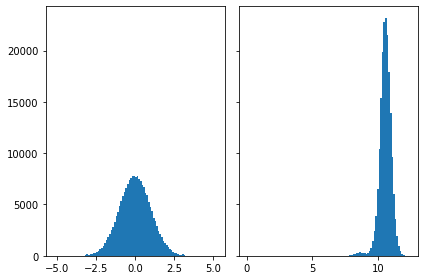

In [ ]:
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
axs[0].hist(y_trans, bins=100)
axs[1].hist(y_train, bins=100)

RidgeCV model

In [ ]:
regr = RidgeCV()
regr_trans = TransformedTargetRegressor(
    regressor=RidgeCV(),
    transformer=QuantileTransformer(n_quantiles=900,
                                    output_distribution='normal'))
regr_trans.fit(X_train, y_train)
y_pred = regr_trans.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("RMSE :", np.sqrt(mse))

RMSE : 0.31857290746785116


In [ ]:
preds = regr_trans.predict(df_test[feature_cols])

In [ ]:
result = pd.DataFrame({"ID": test["ID"], 'Sales':np.expm1(preds)})
result.to_csv("ridge_CV_submission.csv", index=False)